In [44]:
import symnum
import symnum.numpy as snp
import simsde
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [45]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N 
        - snp.exp(log_S + log_C - log_I) / (2 * N) 
        - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [
            -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 
            snp.sqrt(λ) * snp.exp(-log_I / 2), 
            0
        ],
        [0, 0, σ]
    ])
    

def diff_coeff_second(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), -snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), 0],
        [0, snp.sqrt(λ) * snp.exp(-log_I / 2), 0],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

v = [drift_func] + [simsde.operators.subscript_k(diff_coeff, k) for k in range(dim_x)]
x = snp.array(sympy.symbols('log_S, log_I, log_C'))
θ = snp.array(sympy.symbols('α, β, σ, λ, N'))
display(v[2](x, θ))

[-exp(log_C/2 - log_I/2 + log_S/2)/sqrt(N), sqrt(λ)*exp(-log_I/2), 0]

Text(0.5, 0, 'Time')

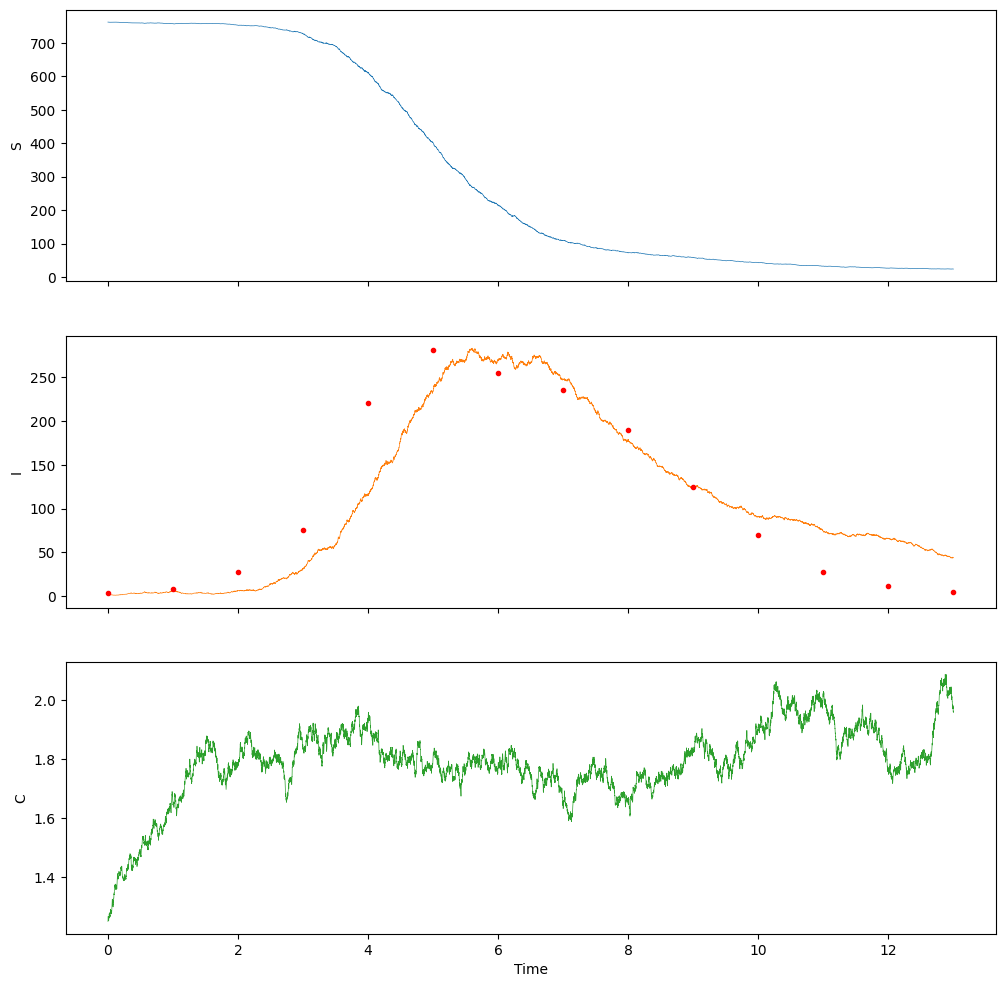

In [46]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763.,  # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff, diff_coeff_second),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.001 
t_max = 13.
dt_observation = 1.
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

#simulation_method = "weak_order_2"
simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221111)
#obs_noise_std = 10.
obs_noise_std = 0.4
x_0_obs = np.log(np.array([762., 1., 1.25]))
#θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
θ_obs = np.array([2.04, 0.592, 0.10, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)
y_obs = np.array([3, 8, 28, 75, 221, 281, 255, 235, 190, 125, 70, 28, 12, 5])

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.05


Sampling stage: Adaptive warm up [03:19] > Main non-adaptive [08:23]

Chain 1/4: 100%|██████████|1000/1000 [02:05<00:00, 7.94it/s, n_step=1.01e+03, accept_stat=0.845]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:06<00:00, 7.92it/s, n_step=1.01e+03, accept_stat=0.837]

Chain 3/4: 100%|██████████|1000/1000 [02:05<00:00, 7.97it/s, n_step=1.01e+03, accept_stat=0.833]

Chain 4/4: 100%|██████████|1000/1000 [02:05<00:00, 7.94it/s, n_step=1.01e+03, accept_stat=0.843]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.103,2.323,0.034,5.674,0.040,0.028,3874.0,3131.0,1.0
β,0.575,0.183,0.296,0.908,0.003,0.002,4058.0,2878.0,1.0
σ,0.233,0.268,0.001,0.676,0.007,0.005,1525.0,2634.0,1.0
λ,0.493,0.021,0.456,0.531,0.000,0.000,7063.0,3052.0,1.0
x_0_2,0.371,0.777,-1.202,1.729,0.011,0.011,5036.0,3092.0,1.0


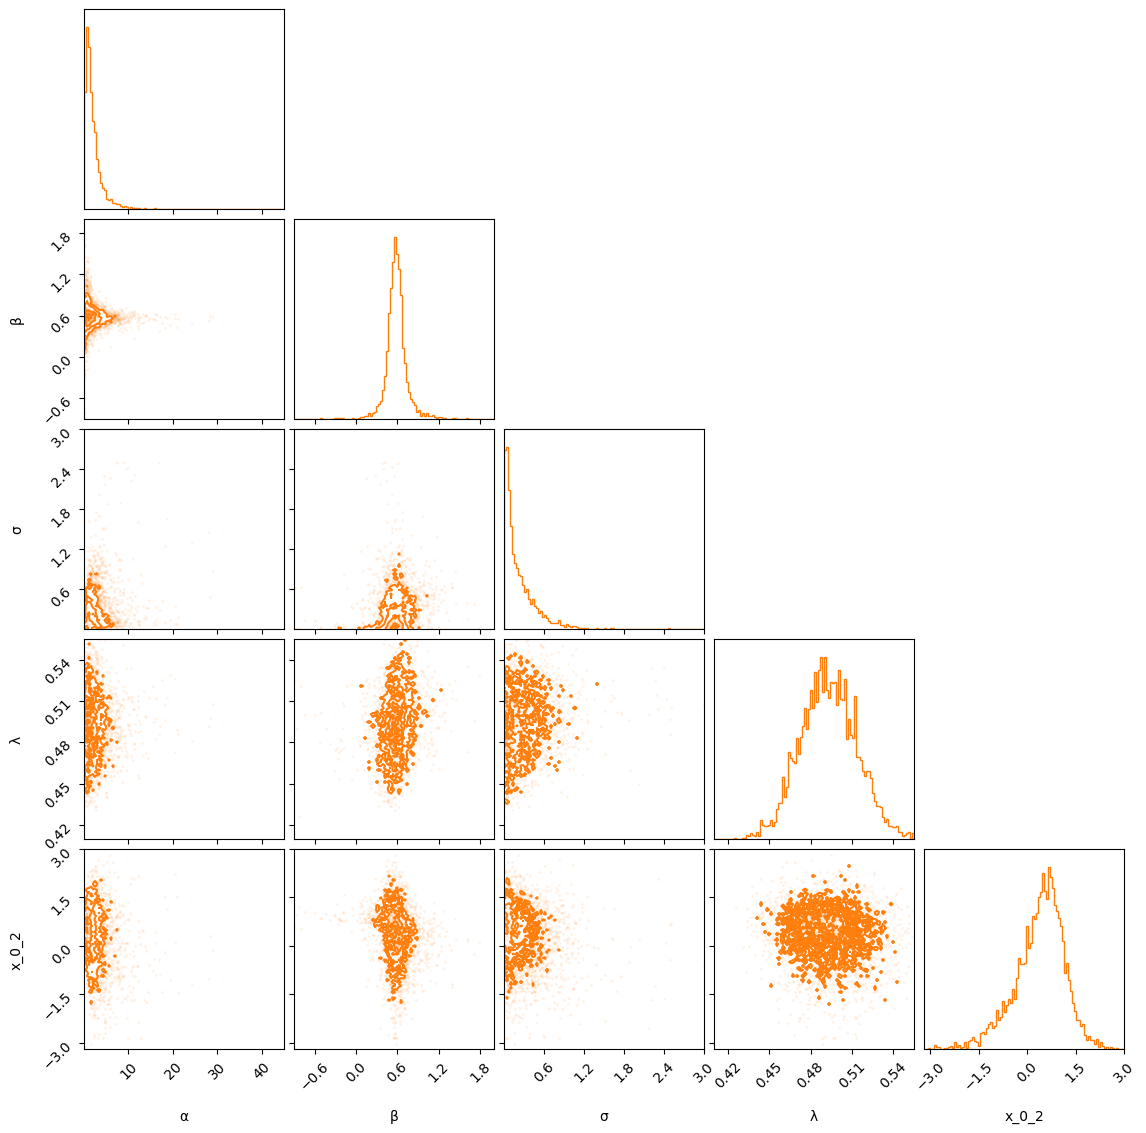

weak_order_2
0.05


Sampling stage: Adaptive warm up [05:45] > Main non-adaptive [14:42]

Chain 1/4: 100%|██████████|1000/1000 [03:38<00:00, 4.58it/s, n_step=1.00e+03, accept_stat=0.830]

Chain 2/4: 100%|██████████|1000/1000 [03:46<00:00, 4.42it/s, n_step=1.01e+03, accept_stat=0.855]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 3/4: 100%|██████████|1000/1000 [03:37<00:00, 4.59it/s, n_step=1.00e+03, accept_stat=0.846]

Chain 4/4: 100%|██████████|1000/1000 [03:39<00:00, 4.55it/s, n_step=1.00e+03, accept_stat=0.849]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.969,2.100,0.052,5.294,0.034,0.027,3876.0,2813.0,1.0
β,0.589,0.167,0.324,0.891,0.003,0.002,3880.0,2969.0,1.0
σ,0.205,0.261,0.002,0.625,0.006,0.005,1781.0,2513.0,1.0
λ,0.482,0.019,0.447,0.518,0.000,0.000,7024.0,2941.0,1.0
x_0_2,0.394,0.715,-1.073,1.678,0.011,0.010,4695.0,3053.0,1.0


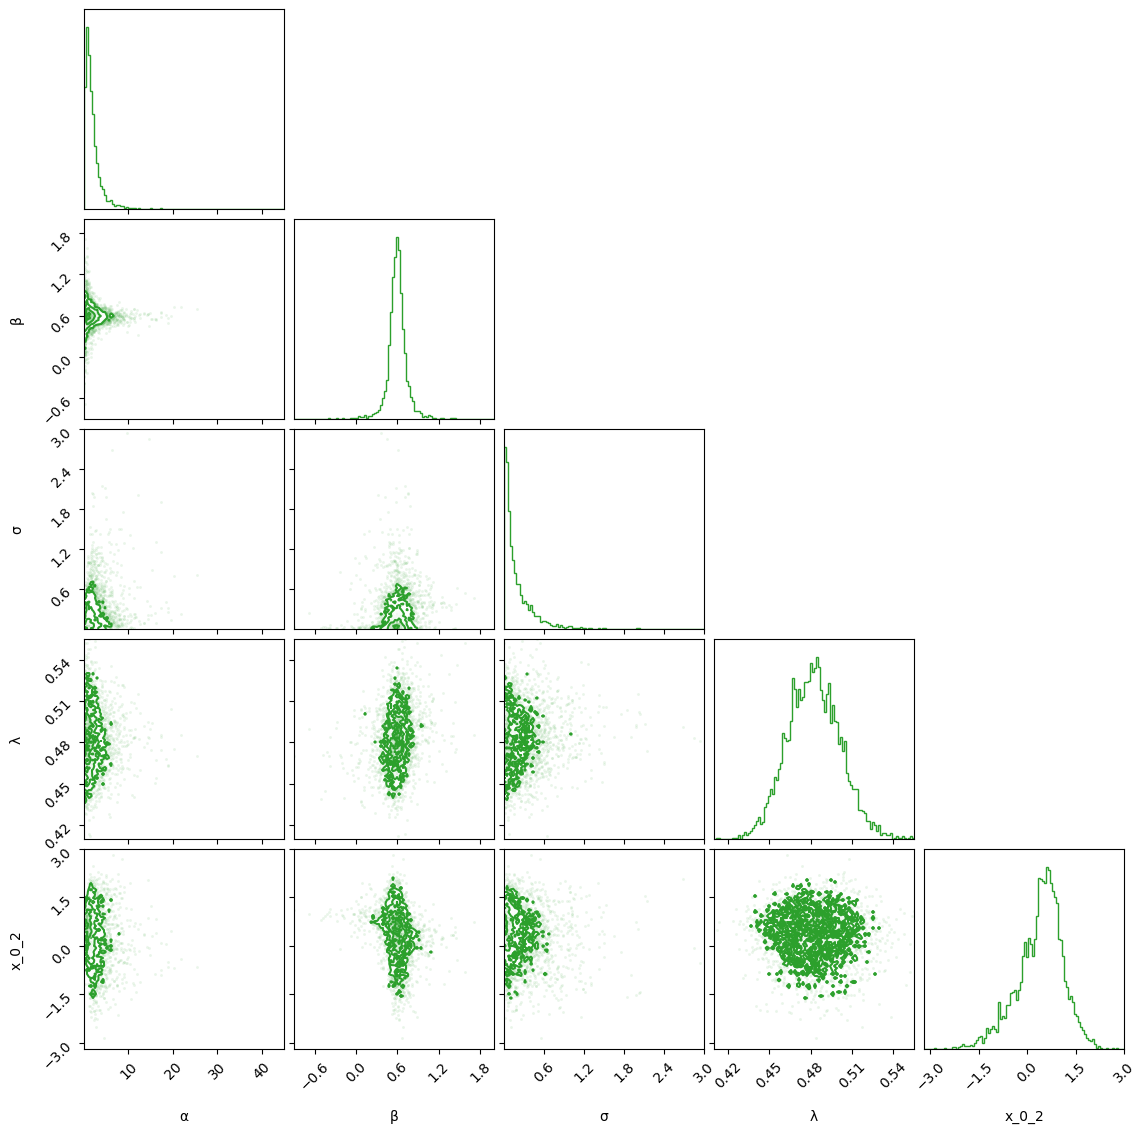

euler_maruyama
0.025


Sampling stage: Adaptive warm up [04:20] > Main non-adaptive [10:56]

Chain 1/4: 100%|██████████|1000/1000 [02:43<00:00, 6.11it/s, n_step=1.01e+03, accept_stat=0.852]

Chain 2/4: 100%|██████████|1000/1000 [02:43<00:00, 6.11it/s, n_step=1.01e+03, accept_stat=0.859]

Chain 3/4: 100%|██████████|1000/1000 [02:43<00:00, 6.11it/s, n_step=1.01e+03, accept_stat=0.843]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [02:45<00:00, 6.06it/s, n_step=1.02e+03, accept_stat=0.861]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.973,2.335,0.037,5.332,0.041,0.029,3982.0,2768.0,1.0
β,0.589,0.179,0.277,0.910,0.003,0.002,4310.0,3163.0,1.0
σ,0.220,0.274,0.002,0.675,0.007,0.005,1430.0,2529.0,1.0
λ,0.487,0.020,0.449,0.525,0.000,0.000,7376.0,2967.0,1.0
x_0_2,0.419,0.708,-0.966,1.749,0.011,0.009,4738.0,2853.0,1.0


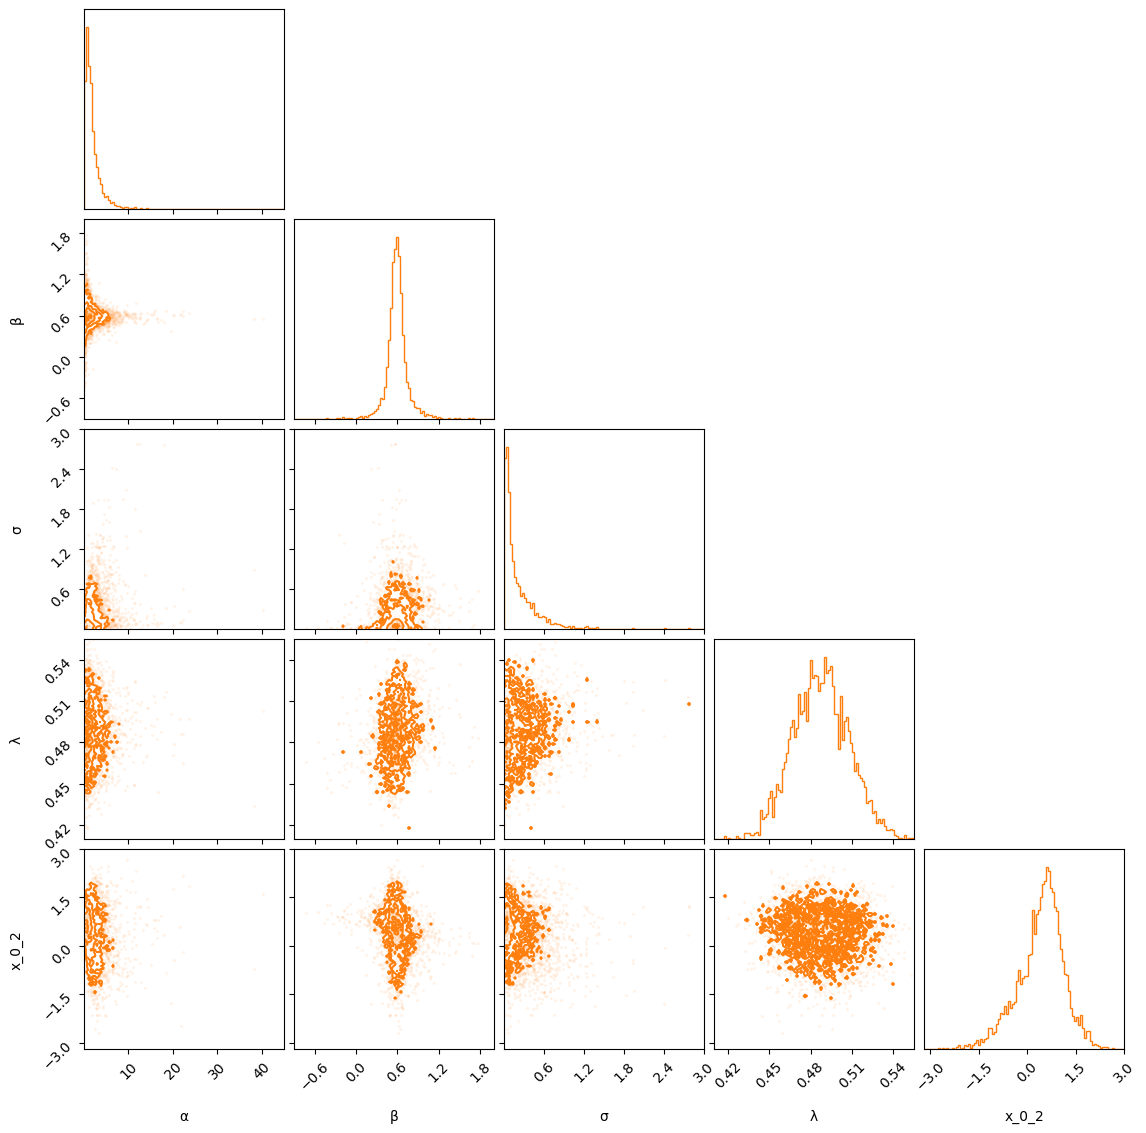

weak_order_2
0.025


Sampling stage: Adaptive warm up [09:19] > Main non-adaptive [23:31]

Chain 1/4: 100%|██████████|1000/1000 [05:49<00:00, 2.86it/s, n_step=996., accept_stat=0.850]

Chain 2/4: 100%|██████████|1000/1000 [05:55<00:00, 2.81it/s, n_step=1.01e+03, accept_stat=0.855]

Chain 3/4: 100%|██████████|1000/1000 [05:54<00:00, 2.82it/s, n_step=1.01e+03, accept_stat=0.855]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [05:51<00:00, 2.84it/s, n_step=997., accept_stat=0.846]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.076,2.442,0.039,5.603,0.043,0.035,4063.0,3271.0,1.0
β,0.596,0.166,0.310,0.904,0.003,0.002,4208.0,3352.0,1.0
σ,0.218,0.284,0.003,0.681,0.009,0.007,1547.0,1891.0,1.0
λ,0.482,0.020,0.445,0.522,0.000,0.000,7987.0,2518.0,1.0
x_0_2,0.379,0.707,-1.019,1.597,0.011,0.009,4282.0,3153.0,1.0


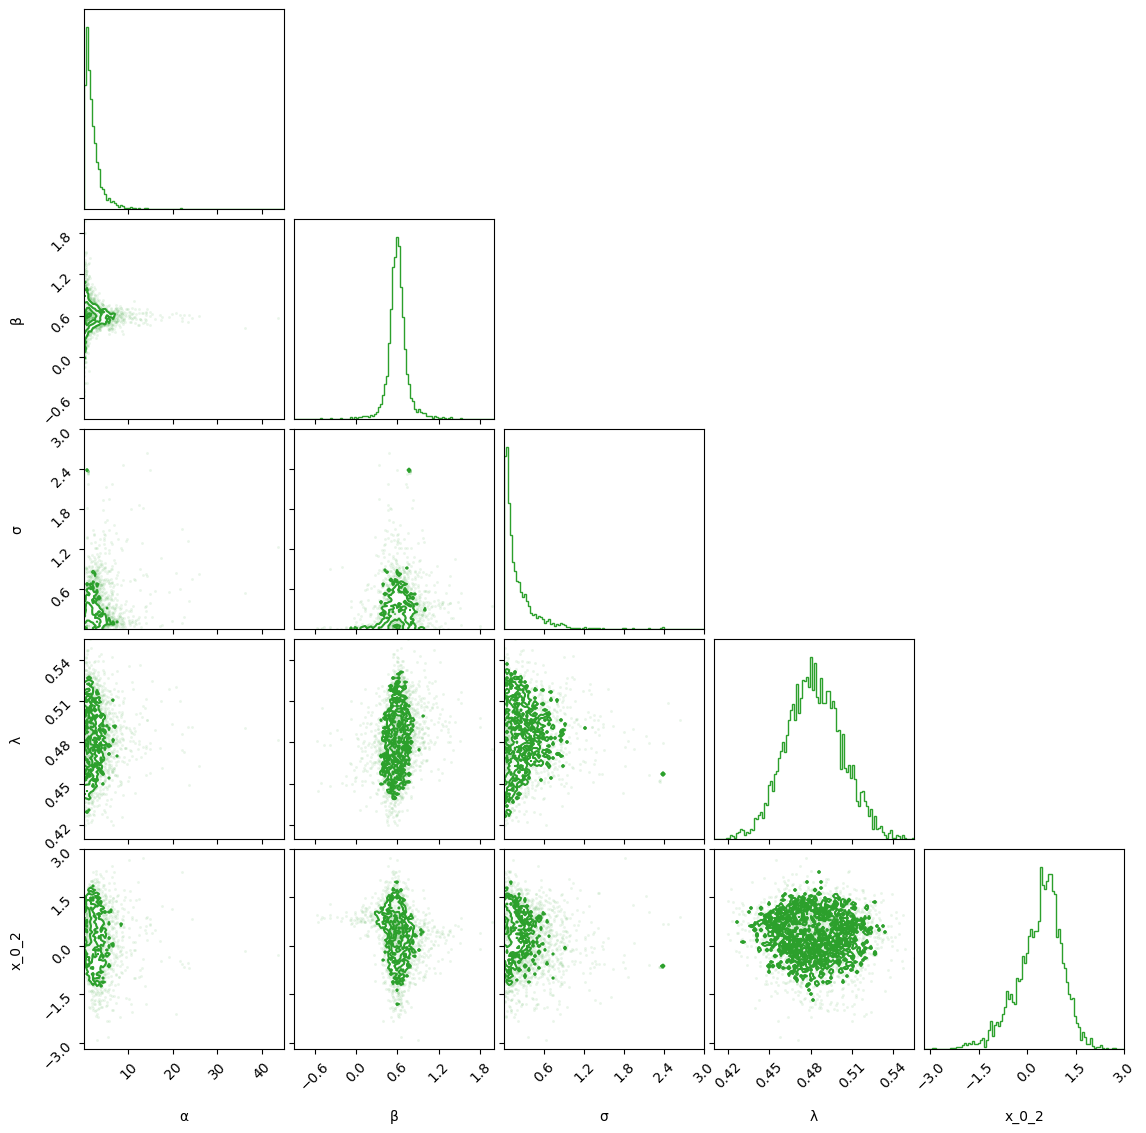

In [47]:
n_chain = 4
#n_warm_up_iter = 1000
n_warm_up_iter = 500
n_main_iter = 1000
dt_inference_seq = np.array([0.05, 0.025])
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        #dt_inference = 200 * dt_simulation
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 5,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20221111)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            bins = 100, 
            range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
            #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
            color=f'C{color}',
            #truth_color="C3"
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1


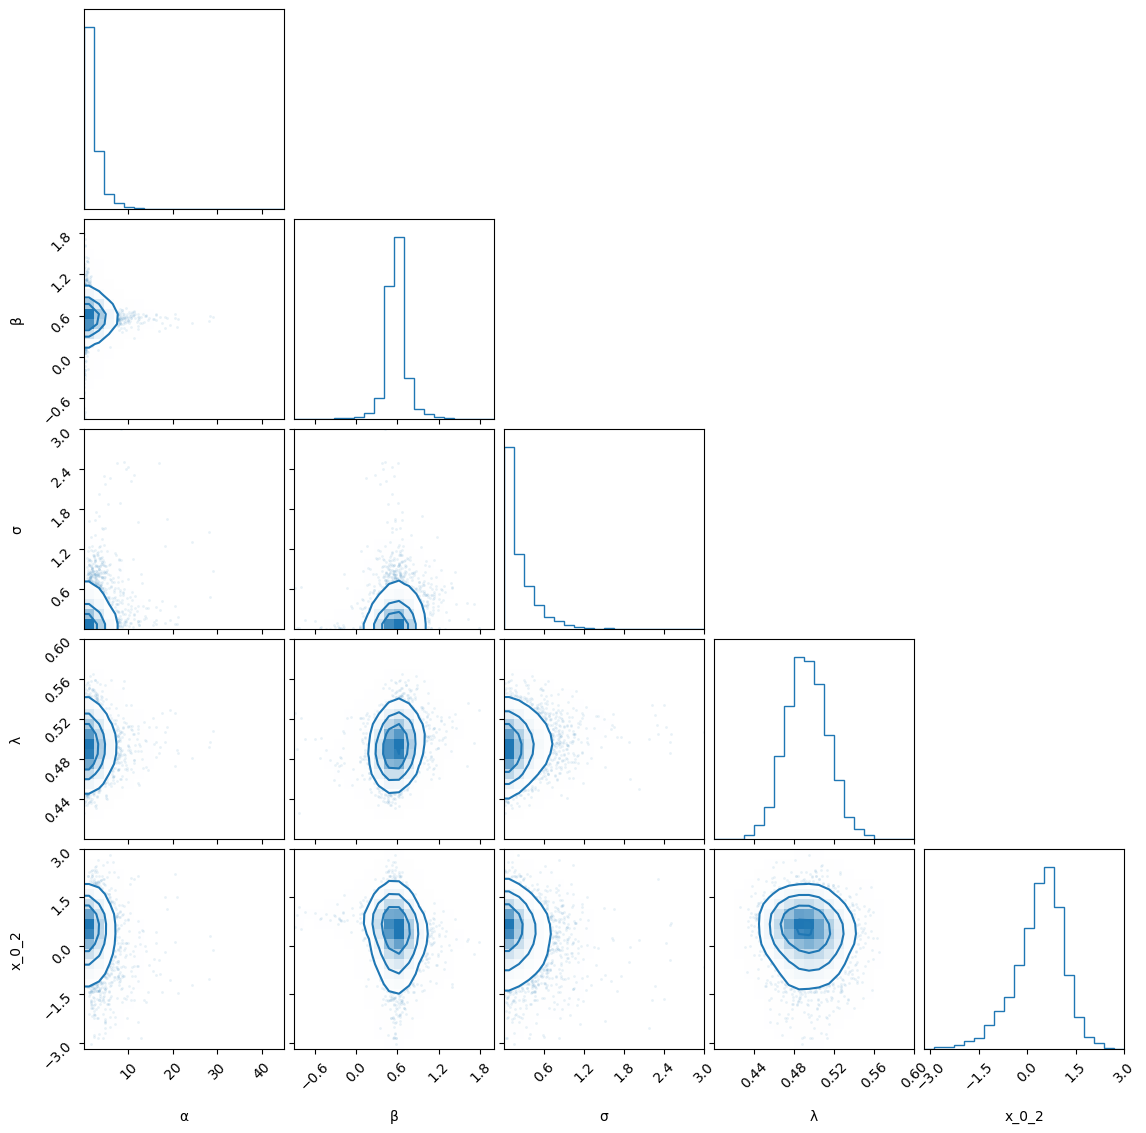

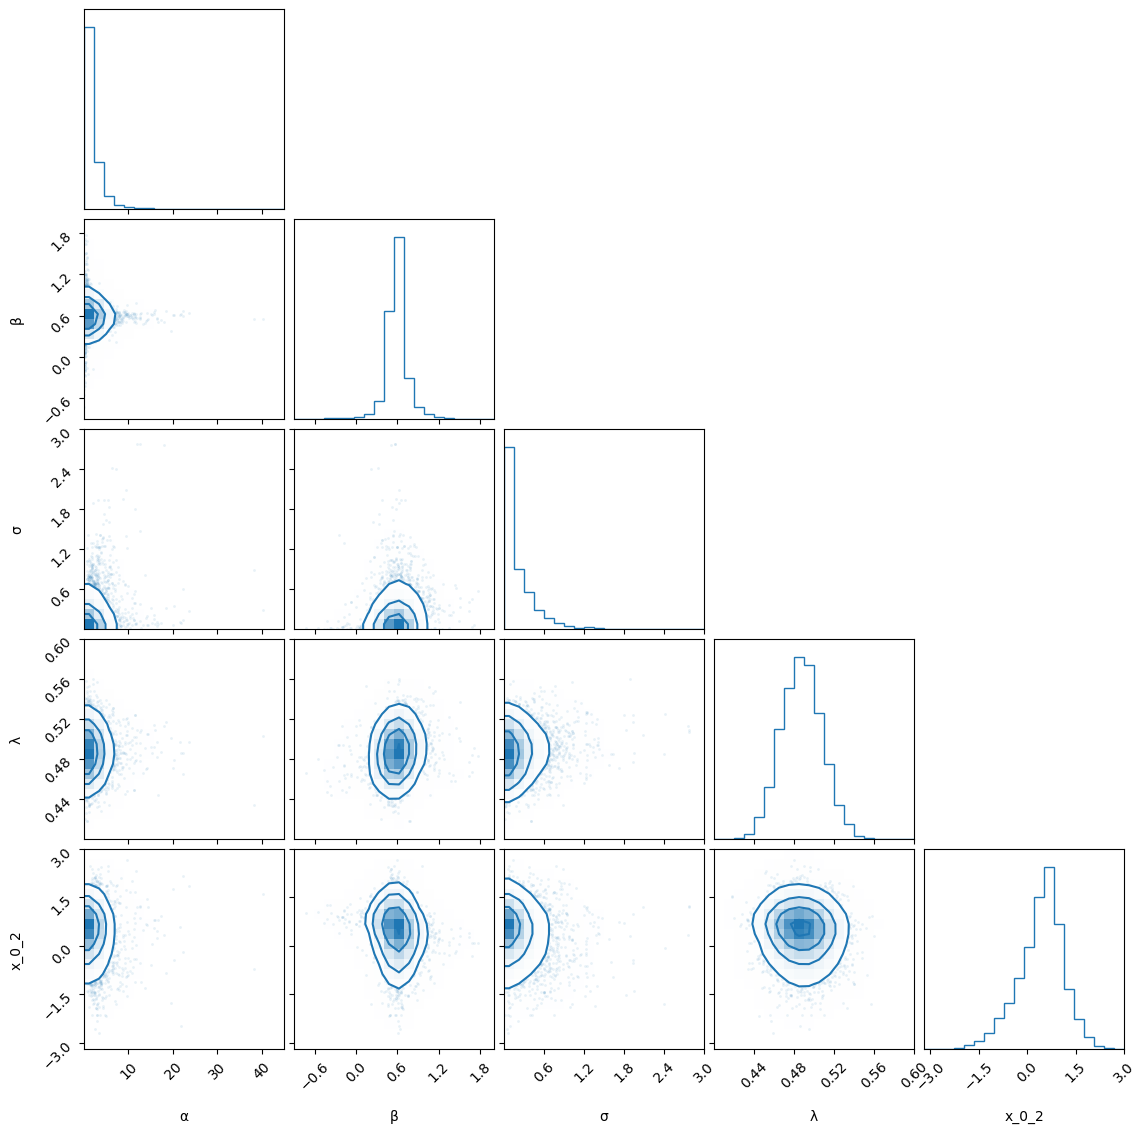

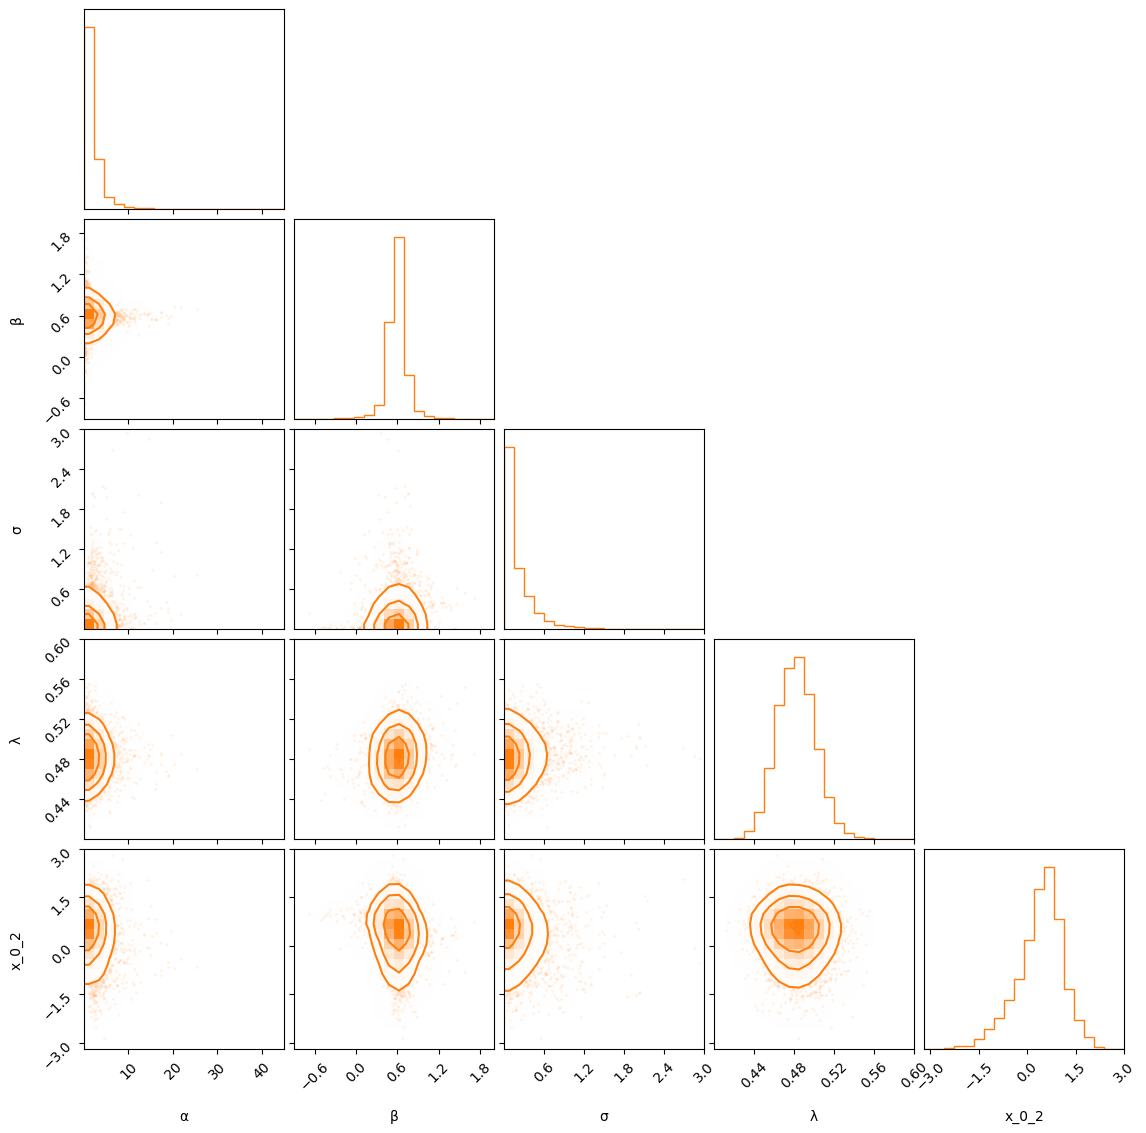

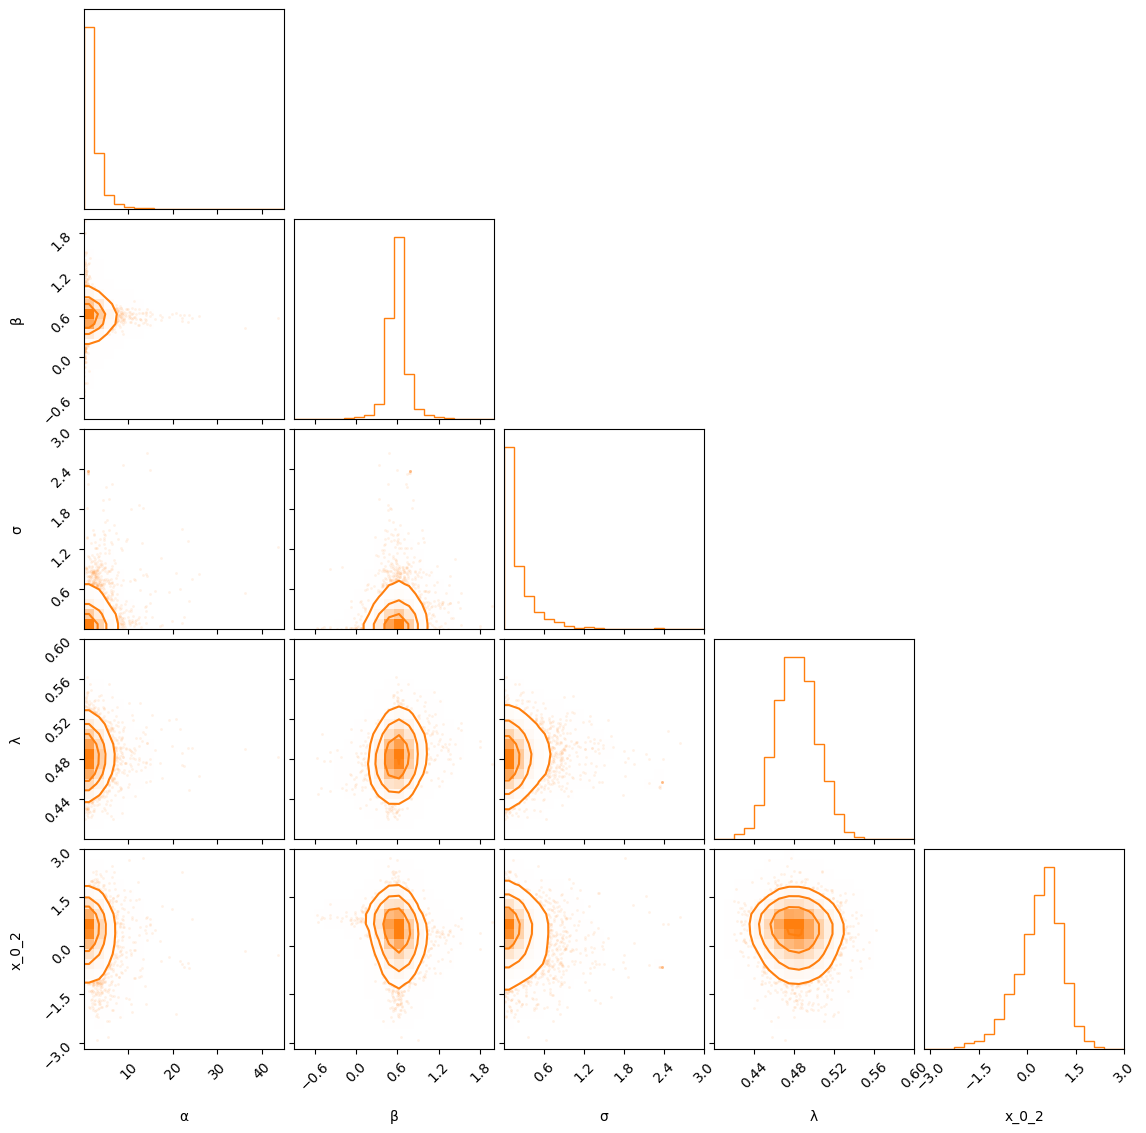

In [57]:

for color in range(2):
    for i in range(dt_inference_seq.size):
        fig = corner.corner(trace[color][i], 
                    range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
                    bins=20,
                    #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
                    color=f'C{color}',
                    smooth=1.0,
                )
        display(fig)
        plt.close(fig)